In [4]:
import scipy as sp
import numpy as np
import seaborn as sns
import mne
import os
%matplotlib inline

In [5]:
root_dir = 'data'

In [6]:
edf_path = os.path.join(root_dir,'NeoRec_2016-08-15_15-47-26.edf')

In [11]:
edf_signal = mne.io.read_raw_edf(edf_path,preload=True)

Extracting edf Parameters from data/NeoRec_2016-08-15_15-47-26.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 482499  =      0.000 ...   964.998 secs...
Ready.


In [12]:
edf_data_frame = edf_signal.to_data_frame()

Converting time column to int64...


In [13]:
edf_data_frame.head()

signal,GSR,PPG,EMGZ,EMGC,Fp1,Fp2,Fz,F3,F4,A1,A2,STI 014
time,,,,,,,,,,,,
0,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0
2,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0
4,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0
6,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0
8,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0


In [14]:
emgz_signal = edf_data_frame['EMGZ']

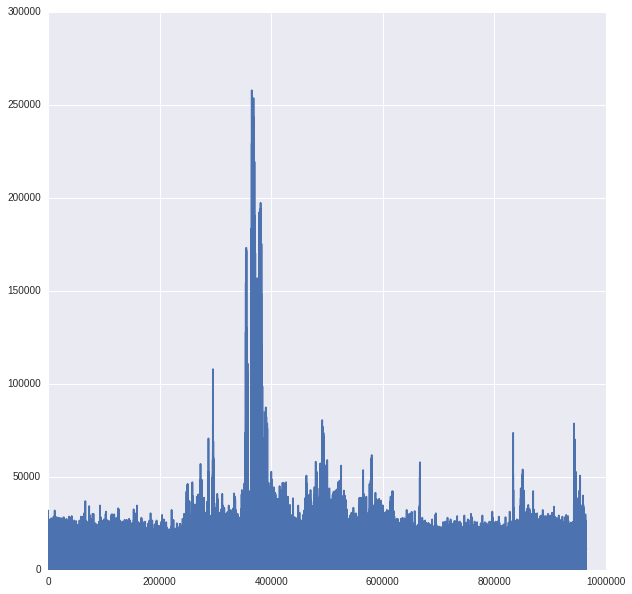

In [38]:
sns.plt.rcParams['figure.figsize']=(10,10)
sns.plt.plot(np.abs(emgz_signal))

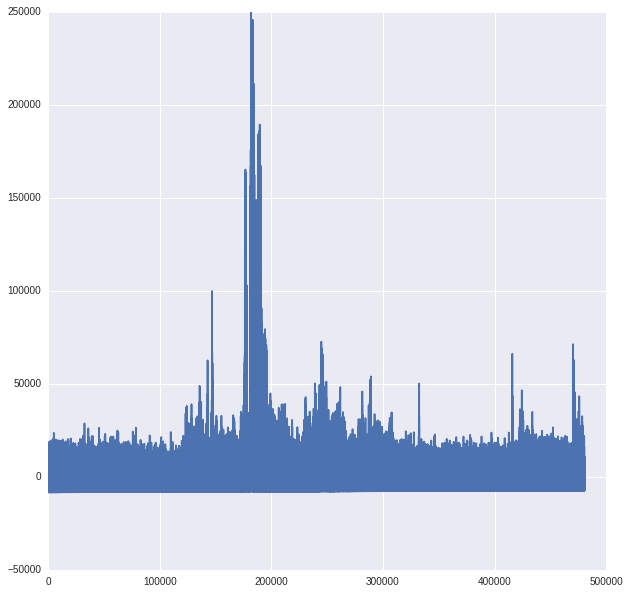

In [41]:
from scipy.signal import detrend

sns.plt.plot(detrend(np.abs(emgz_signal[1000:-1000])))